# Livrable 1

## Import des dépendances

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import time

## Chargement des données

In [2]:
#Paramètres

AUTOTUNE = tf.data.AUTOTUNE
current_dir = pathlib.Path().resolve()
DATASET_SIZE = len(list(current_dir.glob('data/*/*')))

batch_size = 32
img_height = 180
img_width = 180
num_classes = 6

In [11]:
def get_data(relative_pattern, shuffled=True):
    ds = tf.data.Dataset.list_files(str(current_dir / relative_pattern), seed = 123)
    ds = ds.shuffle(DATASET_SIZE) if shuffled else ds
    return ds

paint_ds = get_data('data/Painting/*')
photo_ds = get_data('data/Photo/*')
schema_ds = get_data('data/Schematics/*')
sketch_ds = get_data('data/Sketch/*')
text_ds = get_data('data/Text/*')

data_ds = \
    paint_ds.concatenate(photo_ds)\
    .concatenate(schema_ds)\
    .concatenate(sketch_ds)\
    .concatenate(text_ds)

# no_photo_ds = schema_ds.concatenate(text_ds)
# no_photo_ds.shuffle(DATASET_SIZE)
# print(list(no_photo_ds.as_numpy_iterator()))

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

train_dataset = data_ds.take(train_size)
test_dataset = data_ds.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)
print(list(test_dataset.as_numpy_iterator()))
#
# print(DATASET_SIZE)
# print(tf.data.experimental.cardinality(train_dataset).numpy())
# print(tf.data.experimental.cardinality(test_dataset).numpy())
# print(tf.data.experimental.cardinality(val_dataset).numpy())

[b'C:\\Users\\kevin\\Desktop\\dev_projects\\leyenda_project\\data\\Schematics\\schematics_02133.jpg', b'C:\\Users\\kevin\\Desktop\\dev_projects\\leyenda_project\\data\\Schematics\\schematics_02418.jpg', b'C:\\Users\\kevin\\Desktop\\dev_projects\\leyenda_project\\data\\Schematics\\schematics_06883.jpg', b'C:\\Users\\kevin\\Desktop\\dev_projects\\leyenda_project\\data\\Schematics\\schematics_03382.jpg', b'C:\\Users\\kevin\\Desktop\\dev_projects\\leyenda_project\\data\\Schematics\\schematics_08090.jpg', b'C:\\Users\\kevin\\Desktop\\dev_projects\\leyenda_project\\data\\Schematics\\schematics_02444.jpg', b'C:\\Users\\kevin\\Desktop\\dev_projects\\leyenda_project\\data\\Schematics\\schematics_01030.jpg', b'C:\\Users\\kevin\\Desktop\\dev_projects\\leyenda_project\\data\\Schematics\\schematics_01492.jpg', b'C:\\Users\\kevin\\Desktop\\dev_projects\\leyenda_project\\data\\Schematics\\schematics_09324.jpg', b'C:\\Users\\kevin\\Desktop\\dev_projects\\leyenda_project\\data\\Schematics\\schematics_0

In [13]:
class_names = ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']
# class_names = np.array(sorted([item.name for item in current_dir.glob('data/*')]))
# class_names = ['Photo', 'No photo']
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


# Préparation

In [14]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)


def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [15]:
from tensorflow.python.data import AUTOTUNE

train = train_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
val = val_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
test = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
for image, label in train.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [17]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=12000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train)
val_ds = configure_for_performance(val)
test_ds = configure_for_performance(test)
print(train_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int64)>


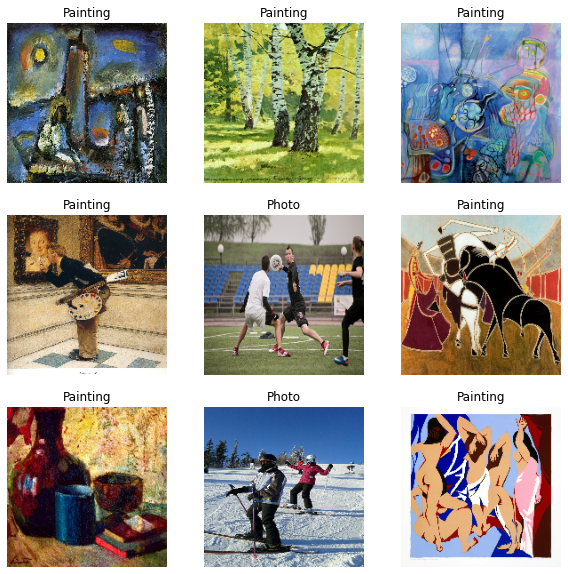

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Création du modèle

In [ ]:
def model_builder(hp):
    inputs = keras.Input(shape=(180, 180, 3))
    # Choose an optimal value between 32-512
    hp_hidden1 = hp.Int('units', min_value=16, max_value=256, step=32)
    hidden1 = keras.layers.Conv2D(hp_hidden1, 3, activation="relu", strides=2, padding="same")(inputs)
    x = keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(16, activation="relu")(x)
    z = keras.layers.Dense(latent_dim)(x)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

    # Tune the number of units in the first Dense layer
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(tf.keras.layers.Dense(2))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    optimizer = hp.Choice('opt', values=['Adam', 'SGD', 'RMSprop'])


    model.compile(optimizer=optimizer(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1. / 255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5)
])

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [22]:
#Utilisation des rappels de point de contrôle

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [23]:
# # Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)

#Entraînement du modèle
model.fit(
    train_ds,
    callbacks=[cp_callback],
    validation_data=val_ds,
    epochs=3,
    shuffle=True
)

Epoch 1/3
478/909 [==============>...............] - ETA: 5:02 - loss: 0.6538 - accuracy: 0.6889

KeyboardInterrupt: 

## Chargement des poids

In [34]:
# checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
# # Load the previously saved weights
model.load_weights(latest)

## Validation des données

In [ ]:
unique_labels = np.unique(class_names)

In [69]:
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """

    return unique_labels[np.argmax(prediction_probabilities)]


def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth and image for sample n
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    # Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Plot image and remove ticks
    plt.imshow(image.astype("uint8"))
    plt.xticks([])
    plt.yticks([])

    # Change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    # Change plot title to be predicted, probability of prediction and truth
    plt.title("{} {:2.0f}% {}".format(pred_label,
                                      np.max(pred_prob) * 100,
                                      true_label),
              color=color)


def unbatchify(data):
    """
    Takes a batch dataset of (image, label) Tensors and returns separate arrays of images and labels
    """
    images = []
    labels = []

    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_labels[np.argmax(label)])

    return images, labels

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence value
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_labels[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass


In [78]:
predictions = model.predict(test_ds)

img, label = unbatchify(test_ds)

In [ ]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=label,
            images=img,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=label,
                 n=i+i_multiplier)
plt.tight_layout()
plt.show


In [80]:
# history = model.history
#
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
#
# loss = history.history['loss']
# val_loss = history.history['val_loss']
#
# epochs_range = range(1)
#
# plt.figure(figsize=(16, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')
#
# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()